In [ ]:
# Load necessary libraries
if (!requireNamespace("readxl", quietly = TRUE)) install.packages("readxl")
if (!requireNamespace("googlesheets4", quietly = TRUE)) install.packages("googlesheets4") # nolint: line_length_linter.

library(readxl)
library(googlesheets4)


In [ ]:
# Define input and output paths
input_path <- "https://docs.google.com/spreadsheets/d/1m3eEaxWT4Unb8jBZWKjiLivavfA0x3PT1F1Rz1eXwVE/edit?gid=0" # nolint
output_path <- "https://docs.google.com/spreadsheets/d/1RzC3DfKNUwYA-qfUN0i53hUwRkWGMBOCoYQqdqG4MQY/edit?gid=0" # nolint

local_input_path <- "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\RegressionDF_forR.csv" # nolint

regression_df <- read.csv(local_input_path)
print(regression_df)


          date       regiao mental_health_visits total_visits periodo
1   2024-12-01          sul               169359      5537357     108
2   2022-07-01          sul               147159      5670166      79
3   2022-11-01          sul               160759      6053194      83
4   2022-10-01          sul               165405      5938846      82
5   2022-09-01          sul               168925      5776479      81
6   2018-04-01          sul                97726      3954977      28
7   2018-05-01          sul                94476      3950949      29
8   2018-06-01          sul                88737      3629643      30
9   2022-08-01          sul               177835      6446181      80
10  2022-06-01          sul               140293      5884884      78
11  2022-02-01          sul               112740      4736730      74
12  2018-07-01          sul                94076      3895748      31
13  2018-08-01          sul               102565      4238054      32
14  2018-09-01      

In [ ]:
install.packages(c("glmmTMB", "lme4", "performance", "DHARMa", "ggplot2", "ggeffects", "purrr", "emmeans"))
library(glmmTMB) # For NB GLMM with autocorrelation
library(lme4) # Alternative for basic GLMM
library(performance) # For model checks
library(DHARMa) # For residual diagnostics
library(ggplot2) # For plots
library(ggeffects)
library(purrr)
library(emmeans)


Warning message:
"os pacotes 'glmmTMB', 'lme4', 'performance', 'DHARMa', 'ggplot2', 'ggeffects', 'purrr' estão em uso e não serão instalados"
Instalando pacote em 'C:/Users/Lucas/AppData/Local/R/win-library/4.5'
(como 'lib' não foi especificado)

instalando as dependências 'estimability', 'mvtnorm' também




pacote 'estimability' desempacotado com sucesso e somas MD5 verificadas
pacote 'mvtnorm' desempacotado com sucesso e somas MD5 verificadas
pacote 'emmeans' desempacotado com sucesso e somas MD5 verificadas

Os pacotes binários baixados estão em
	C:\Users\Lucas\AppData\Local\Temp\RtmpOUiIFu\downloaded_packages


Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'



In [ ]:
# First ensure your time variable is a factor
regression_df$periodo_fac <- as.factor(regression_df$periodo)

# First, run the model with a consistent name
model <- glmmTMB(
  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +
    PosPandemia_Step + PosPandemia_Trend +
    (1 + periodo | regiao)
  #+ ar1(periodo_fac + 0 | regiao)
  ,
  family = nbinom2(),
  offset = log(total_visits / 1000),
  data = regression_df
)
# 1. Model Summary Interpretation
summary(model)

# Key components to check:
# - Fixed effects (global trends)
# - Random effects variance (region differences)
# - AR1 parameter (temporal autocorrelation)


 Family: nbinom2  ( log )
Formula:          
mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +  
    PosPandemia_Step + PosPandemia_Trend + (1 + periodo | regiao)
Data: regression_df
 Offset: log(total_visits/1000)

      AIC       BIC    logLik -2*log(L)  df.resid 
  10899.8   10942.8   -5439.9   10879.8       530 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev. Corr  
 regiao (Intercept) 2.95e-01 0.543180       
        periodo     2.63e-05 0.005129 -0.95 
Number of obs: 540, groups:  regiao, 5

Dispersion parameter for nbinom2 family ():  121 

Conditional model:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)        2.2755948  0.2431979   9.357  < 2e-16 ***
periodo            0.0147627  0.0023268   6.345 2.23e-10 ***
Pandemia_Step      0.0954822  0.0203927   4.682 2.84e-06 ***
Pandemia_Trend    -0.0164479  0.0012469 -13.191  < 2e-16 ***
PosPandemia_Step  -0.2453397  0.0247209  -9.924  < 2e-16 ***
PosPandemia_Trend 

Some of the focal terms are of type `character`. This may lead to
  unexpected results. It is recommended to convert these variables to
  factors before fitting the model.
  The following variables are of type character: `regiao`



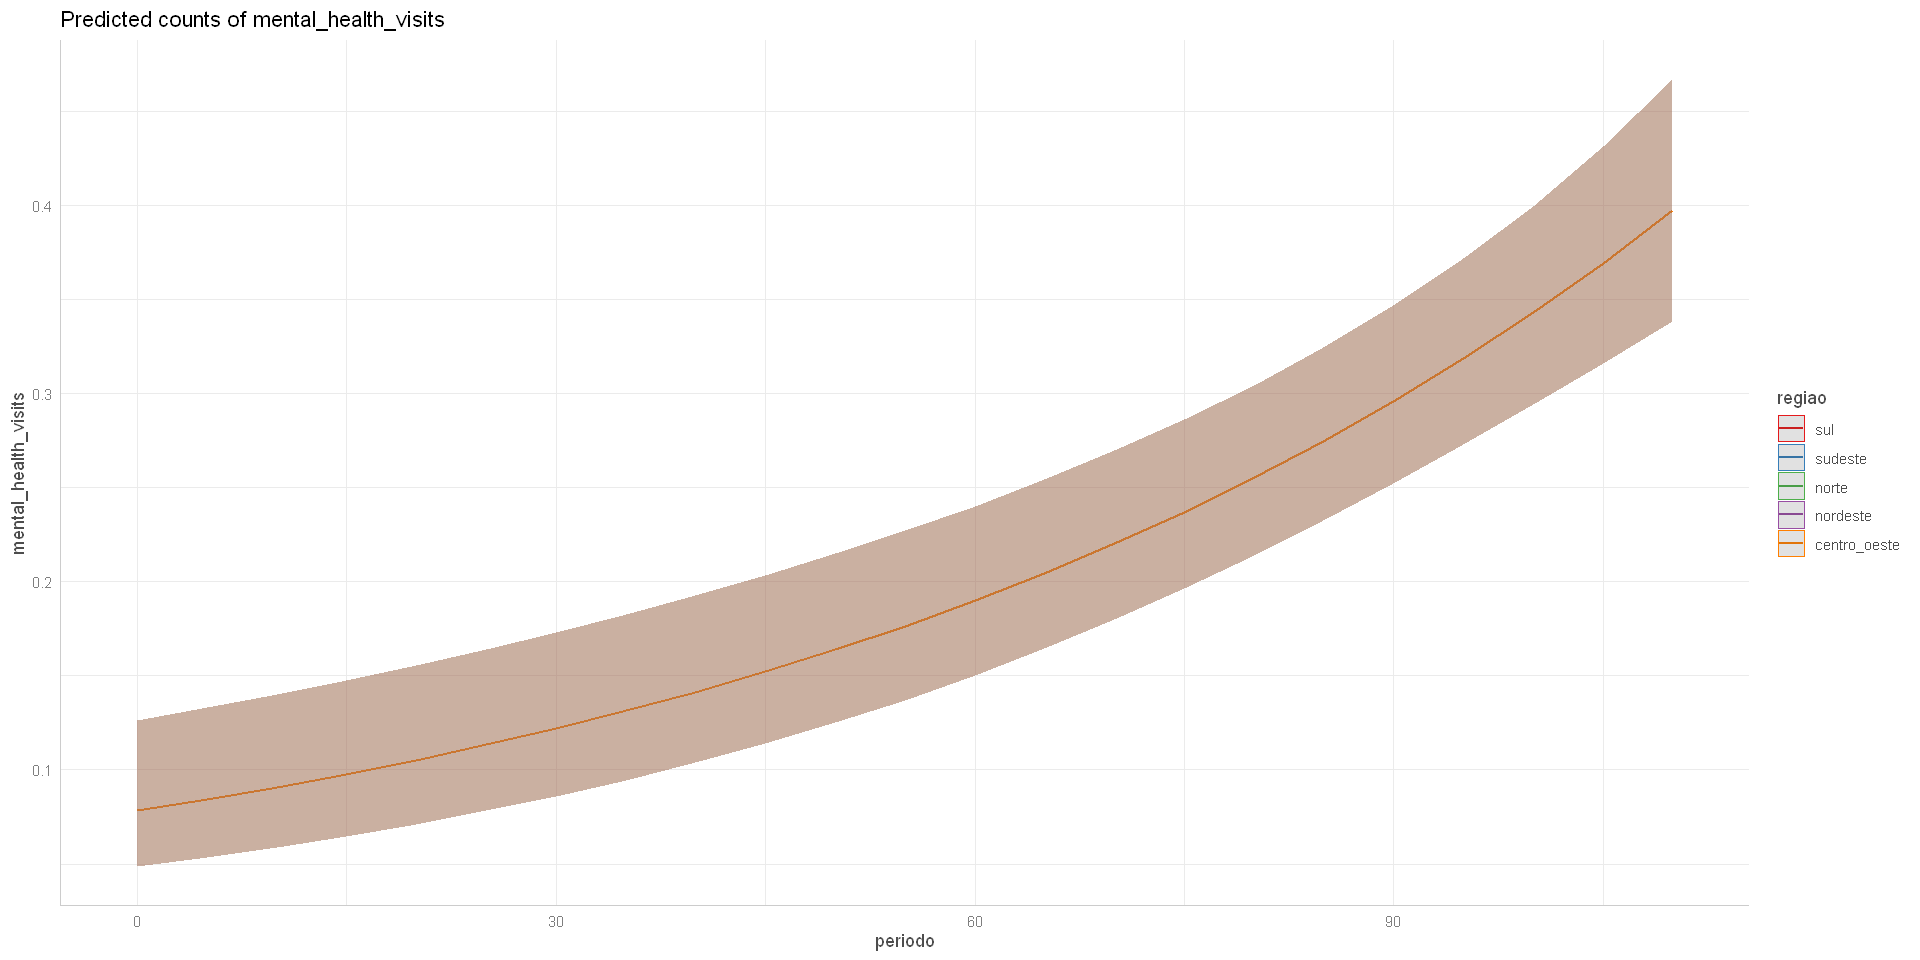

In [ ]:
preds <- ggpredict(model, terms = c("periodo", "regiao"))
plot(preds) # Plot trends by region


In [ ]:
emmeans(model, pairwise ~ regiao, adjust = "tukey") # Post-hoc tests


ERROR: Error in emmeans(model, pairwise ~ regiao, adjust = "tukey"): No variable named regiao in the reference grid


In [ ]:
# Check random effects distribution
qqnorm(ranef(model)$regiao[[1]])

# Residual diagnostics (DHARMa)
sim_res <- simulateResiduals(model)
plot(sim_res)


ERROR: Error in qqnorm.default(ranef(model)$regiao[[1]]): y está vazio ou tem apenas NAs


In [ ]:
# Fit a model WITHOUT random slopes for pandemic
model_fixed <- update(model, . ~ . - (1 + periodo | regiao) + (1 | regiao))

# Likelihood Ratio Test
anova(model, model_fixed)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
model_fixed,8,11637.59,11671.92,-5810.795,11621.59,NA,NA,NA
model,10,10899.85,10942.76,-5439.924,10879.85,741.7426,2,8.563348e-162


In [ ]:
# Example for Sul (Intercept = +0.30)
sul_effect <- fixef(model)["Pandemia_Step"] + ranef(model)$regiao["sul", "Pandemia_Step"]
exp(sul_effect) # IRR for Sul


ERROR: Error in fixef(model)["Pandemia_Step"] + ranef(model)$regiao["sul", "Pandemia_Step"]: argumento não-numérico para operador binário


             (Intercept)       periodo
centro_oeste   0.2287115 -0.0015480950
nordeste      -0.5938839  0.0070915251
norte         -0.6374099  0.0033726657
sudeste        0.2180969 -0.0007617275
sul            0.7840851 -0.0081541600


Some of the focal terms are of type `character`. This may lead to
  unexpected results. It is recommended to convert these variables to
  factors before fitting the model.
  The following variables are of type character: `regiao`



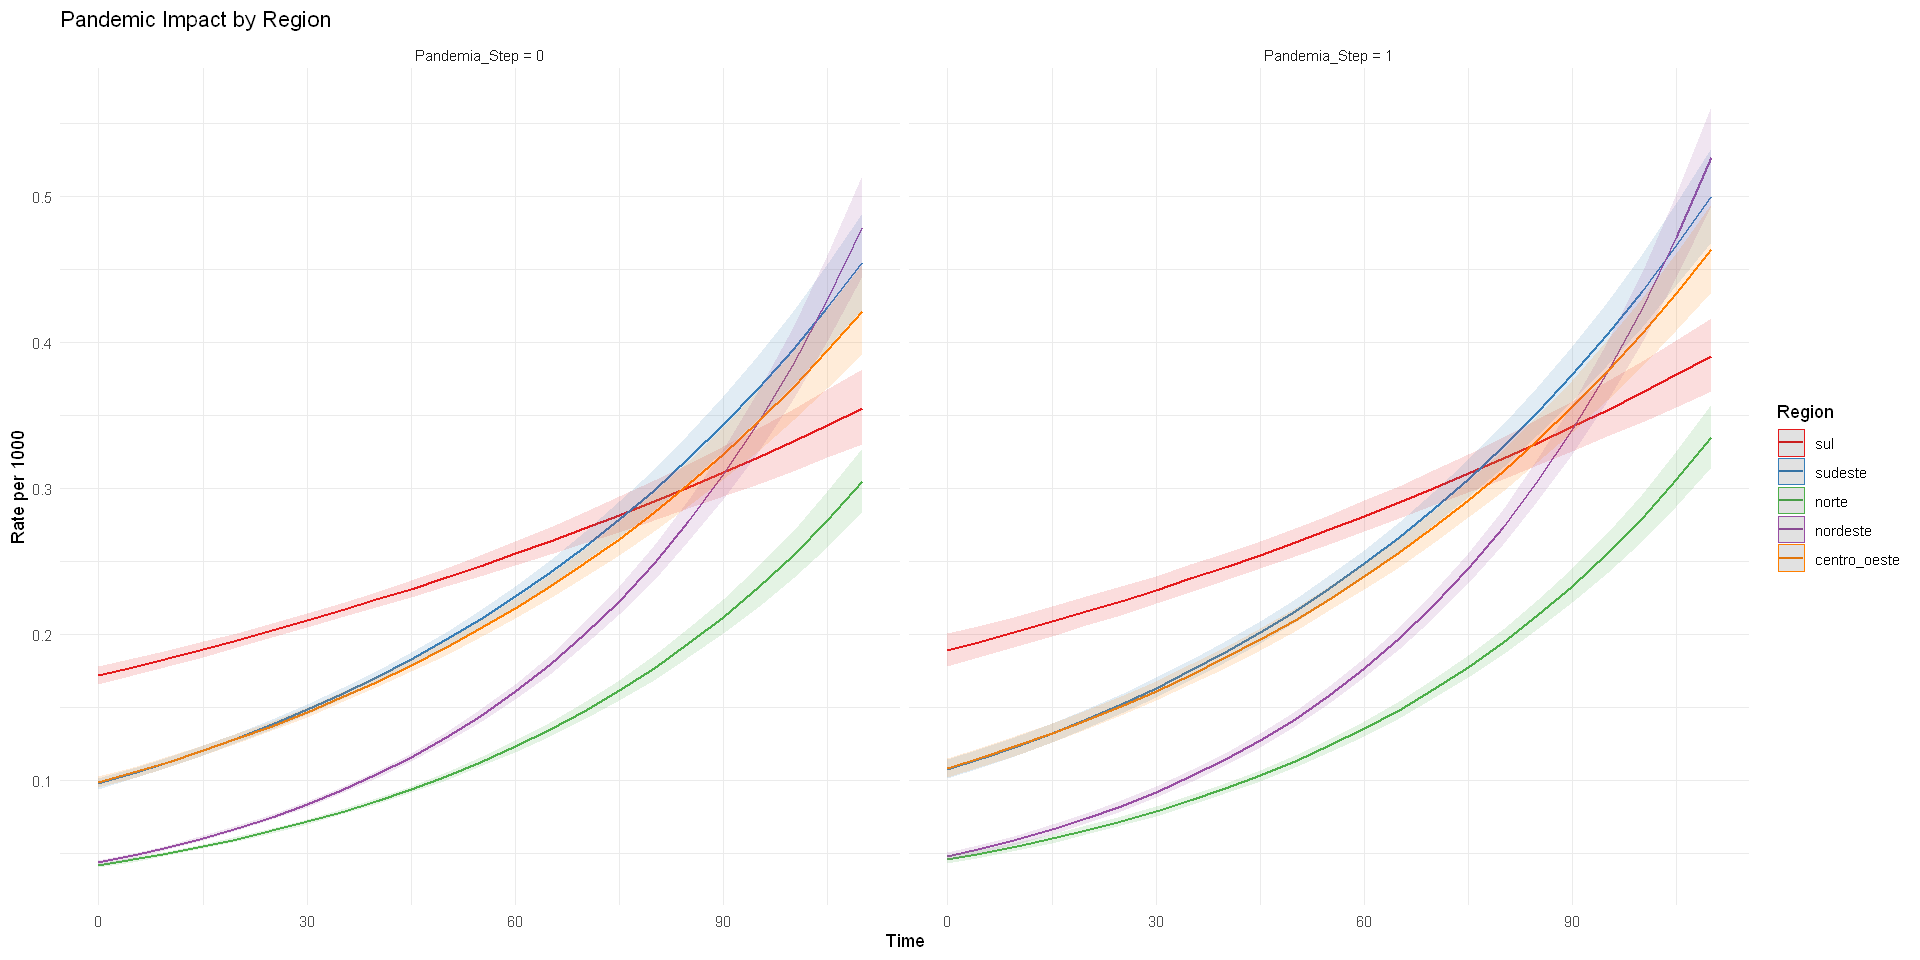

In [ ]:
# Extract random effects properly
random_effects <- ranef(model)
region_effects <- random_effects$cond$regiao # This is where the random effects are stored
print(region_effects)

# Get predictions
preds <- ggpredict(model,
     terms = c("periodo", "regiao", "Pandemia_Step [0,1]"),
     type = "random"
)

# Plot
plot(preds) +
     labs(
          title = "Pandemic Impact by Region",
          x = "Time",
          y = "Rate per 1000",
          color = "Region"
     ) +
     theme_minimal()


In [ ]:
# Get region-specific intercepts and slopes
region_intercepts <- fixef(model)$cond[1] + ranef(model)$cond$regiao[, 1]
region_slopes <- fixef(model)$cond[2] + ranef(model)$cond$regiao[, 2]

# Calculate region-specific pandemic effects
pandemic_effects <- data.frame(
  Region = rownames(ranef(model)$cond$regiao),
  Intercept = exp(region_intercepts),
  Trend_During_Pandemic = fixef(model)$cond["Pandemia_Trend"] + ranef(model)$cond$regiao[, "periodo"]
)

print(pandemic_effects)


        Region Intercept Trend_During_Pandemic
1 centro_oeste 12.235068          -0.017995996
2     nordeste  5.374743          -0.009356375
3        norte  5.145820          -0.013075235
4      sudeste 12.105885          -0.017209628
5          sul 21.320731          -0.024602061


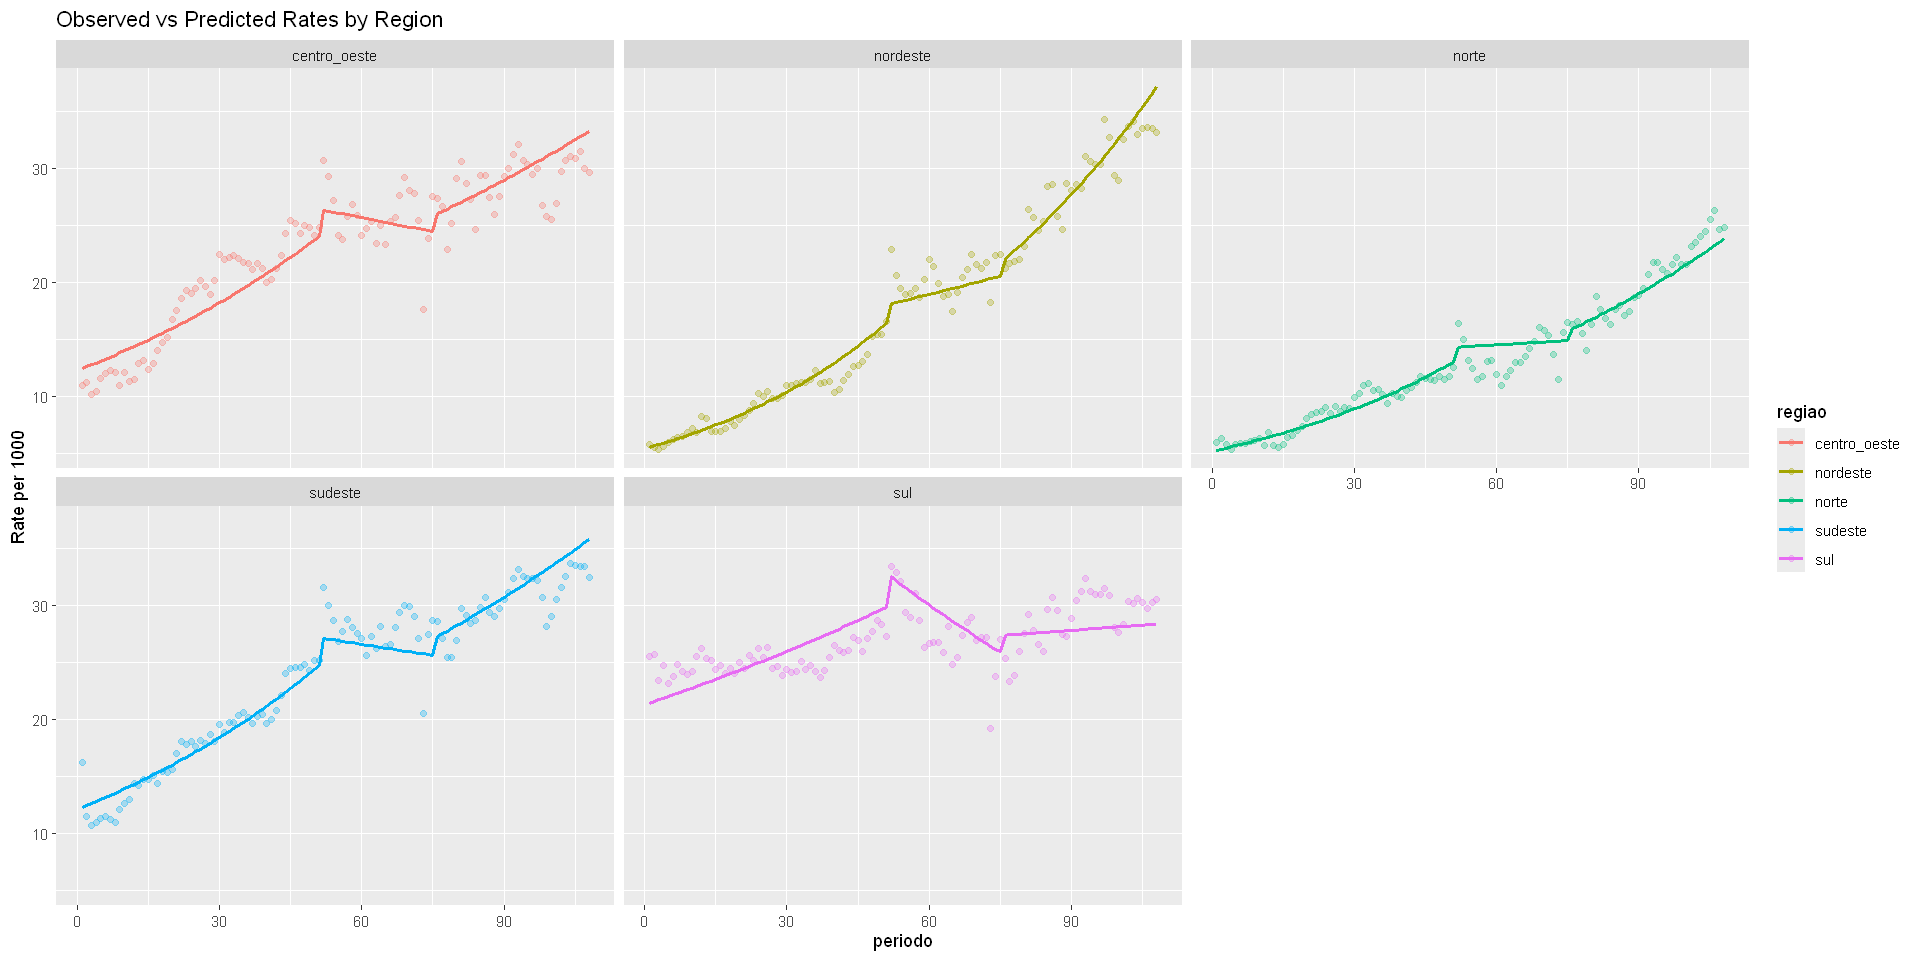

In [ ]:
# Alternative plot with observed vs predicted
options(repr.plot.width = 16, repr.plot.height = 8) # Para Jupyter Notebook/RMarkdown
regression_df$pred <- predict(model, type = "response")

ggplot(regression_df, aes(periodo, mental_health_visits / (total_visits / 1000), color = regiao)) +
  geom_point(alpha = 0.3) +
  geom_line(aes(y = pred / (total_visits / 1000)), size = 1) +
  facet_wrap(~regiao) +
  labs(
    title = "Observed vs Predicted Rates by Region",
    y = "Rate per 1000"
  )
